In [ ]:
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import entropy
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from tensorflow.keras.models import save_model

import cv2 # Import OpenCV
from tqdm import tqdm

In [ ]:
import random

seed = 42

# Python's built-in random library
random.seed(seed)

# Scikit-learn (only affects some parts of scikit-learn)
from sklearn.utils import check_random_state
check_random_state(seed)

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [ ]:
img_rows = 168
img_cols = 168
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

In [ ]:
# Set path for data source
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
weather = pd.read_csv('weather.csv')
metadata = pd.read_csv('metadata.csv')

In [ ]:
df_meter = []
df_meta = []

for meter_data_cleand in os.listdir():
    if meter_data_cleand.endswith('_cleaned.csv'):
        meter_type = meter_data_cleand.split('_cleaned.csv')[0]
        df_meter_data_cleand = pd.read_csv(meter_data_cleand, index_col='timestamp')

        df_meta_cleand = metadata.set_index('building_id').loc[df_meter_data_cleand.columns]
        df_meta.append(df_meta_cleand)

        df_meter_data_cleand.columns = meter_type+'_'+df_meter_data_cleand.columns
        df_meter.append(df_meter_data_cleand)

df_meter = pd.concat(df_meter, axis=1)

df_meta = pd.concat(df_meta, axis=0)
df_meta = df_meta.reset_index().rename(columns={'index':'building_id'})
df_meta.index = df_meter.columns

In [ ]:
df_meta.loc[df_meta['lat'].isna(),'lat'] = df_meta.groupby('timezone')['lat'].transform('mean').loc[df_meta['lat'].isna()]
df_meta.loc[df_meta['lng'].isna(),'lng'] = df_meta.groupby('timezone')['lng'].transform('mean').loc[df_meta['lng'].isna()]
df_meta['meter'] = df_meta.index.str.split('_',expand=True).get_level_values(0)
df_meta['primary_use'] = df_meta.index.str.split('_',expand=True).get_level_values(2)

In [ ]:
df_meter = df_meter.loc[:, df_meter.isna().mean()<0.05]
df_meta = df_meta.loc[df_meter.columns]

In [ ]:
df_meta = df_meta[df_meta.groupby(['primaryspaceusage'])['building_id'].transform('count')>100]
df_meta = df_meta[df_meta.groupby(['meter'])['building_id'].transform('count')>100]
df_meter = df_meter.loc[:, df_meta.index]

In [ ]:
train_data_2016 = df_meter.fillna(method='ffill').fillna(method='bfill').loc[pd.to_datetime(df_meter.index).year==2016]
train_data_2016 = pd.concat([train_data_2016.iloc[24*3:], train_data_2016.iloc[:24*3]],axis=0)
train_data_2016.columns = train_data_2016.columns+'_2016'
train_data_2017 = df_meter.fillna(method='ffill').fillna(method='bfill').loc[pd.to_datetime(df_meter.index).year==2017]
train_data_2017 = pd.concat([train_data_2017.iloc[24*1:], train_data_2017.iloc[:24*1]],axis=0)
train_data_2017.columns = train_data_2017.columns+'_2017'

train_data = pd.concat([train_data_2016.reset_index(drop=True), train_data_2017.reset_index(drop=True)], axis=1)

train_data = train_data.iloc[:168*52]

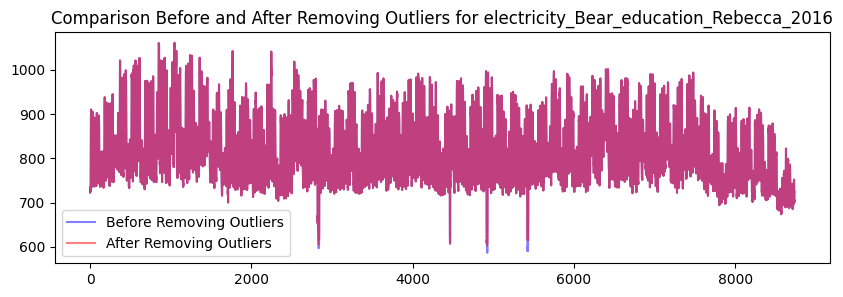

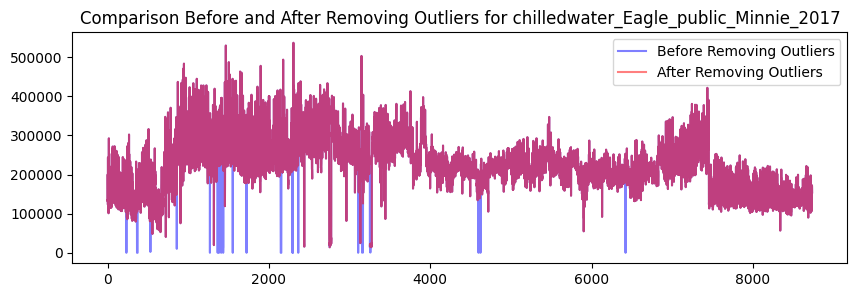

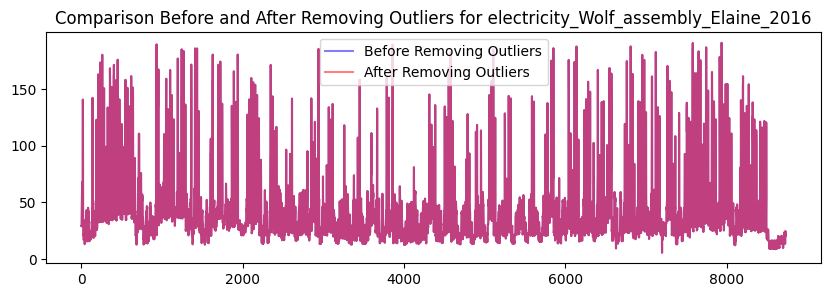

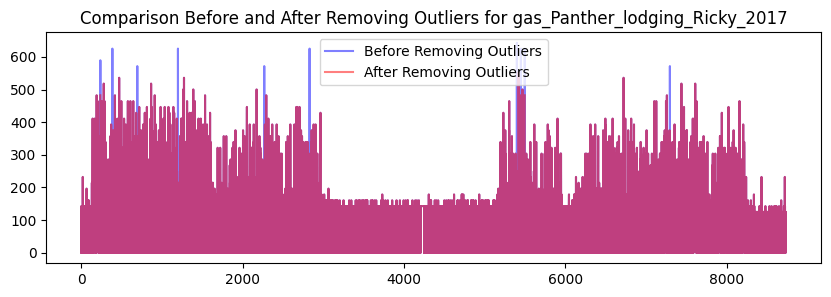

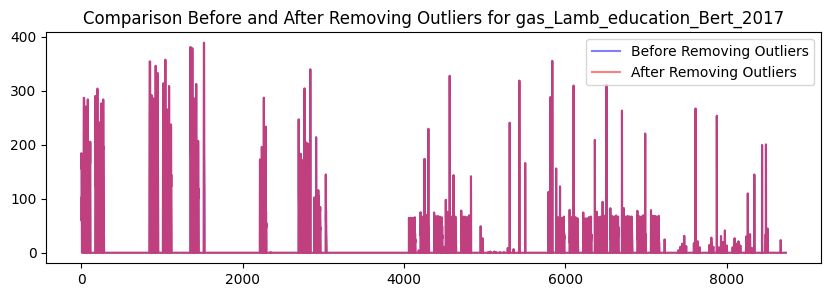

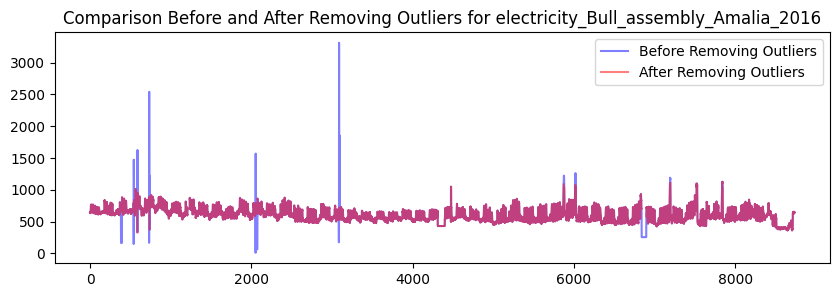

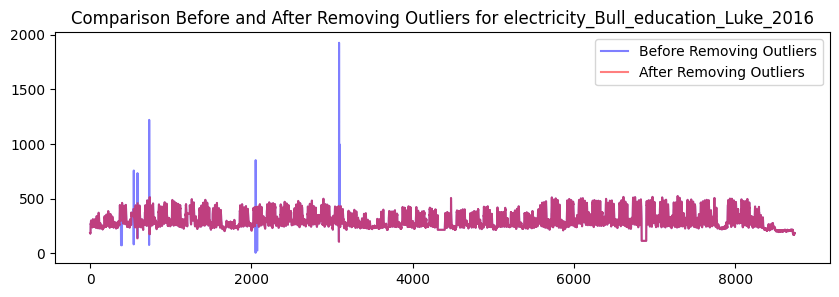

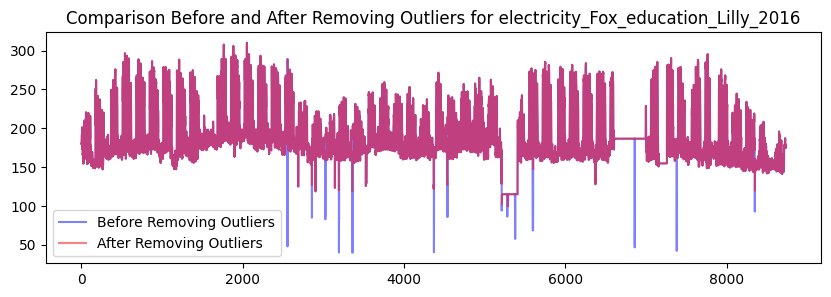

In [ ]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df):
    Q1 = df[df>0].quantile(0.05)
    Q3 = df[df>0].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 0.5 * IQR
    upper_bound = Q3 + 1.0 * IQR
    df[(df < lower_bound) | (df > upper_bound)] = np.nan
    return df

col_list = ['electricity_Bear_education_Rebecca_2016','chilledwater_Eagle_public_Minnie_2017','electricity_Wolf_assembly_Elaine_2016','gas_Panther_lodging_Ricky_2017','gas_Lamb_education_Bert_2017','electricity_Bull_assembly_Amalia_2016',
 'electricity_Bull_education_Luke_2016',
 'electricity_Fox_education_Lilly_2016']

for col in col_list:

  # Create a subplot for better control over plot elements
  fig, ax = plt.subplots(figsize=(10, 3))

  # Plot original data
  ax.plot(train_data.index, train_data[col], label='Before Removing Outliers', color='b', alpha=0.5)

  # Remove outliers
  filtered_data = remove_outliers_iqr(train_data[col])

  # Plot data after removing outliers
  ax.plot(filtered_data.index, filtered_data, label='After Removing Outliers', color='r', alpha=0.5)

  # Add title and legend
  ax.set_title('Comparison Before and After Removing Outliers for '+ col)
  ax.legend()

  # Show the plot
  plt.show()

In [ ]:
for col in tqdm(train_data.columns):
  train_data.loc[:,col] = remove_outliers_iqr(train_data[col])
  train_data.loc[:,col] = train_data.loc[:,col].fillna(method='ffill').fillna(method='bfill')

100%|██████████| 3656/3656 [00:29<00:00, 125.60it/s]


In [ ]:
train_data = (train_data-train_data.min())/(train_data.max()-train_data.min())
train_data = (train_data-0.5)*2

train_data = train_data.dropna(axis=1, how='all')

train_data = train_data.sample(frac=1, axis=1, random_state=42)#shuffle meters

In [ ]:
test_data = train_data.sample(frac=0.25, random_state=42, axis=1)
train_data = train_data.drop(test_data.columns, axis=1)

X_train = train_data.T.to_numpy().reshape(train_data.shape[1], 52, 168)
X_train = X_train[:,:52,:]

X_test = test_data.T.to_numpy().reshape(test_data.shape[1], 52, 168)
X_test = X_test[:,:52,:]

In [ ]:
X_train = np.expand_dims(X_train, axis=3)
X_train = tf.image.resize(X_train, [img_rows, img_cols]).numpy()
X_train.shape

(2702, 168, 168, 1)

In [ ]:
X_test = np.expand_dims(X_test, axis=3)
X_test = tf.image.resize(X_test, [img_rows, img_cols]).numpy()
X_test.shape

(901, 168, 168, 1)

In [ ]:
df_meta.loc[df_meta['lat'].isna(),'lat'] = df_meta.groupby('timezone')['lat'].transform('mean').loc[df_meta['lat'].isna()]
df_meta.loc[df_meta['lng'].isna(),'lng'] = df_meta.groupby('timezone')['lng'].transform('mean').loc[df_meta['lng'].isna()]

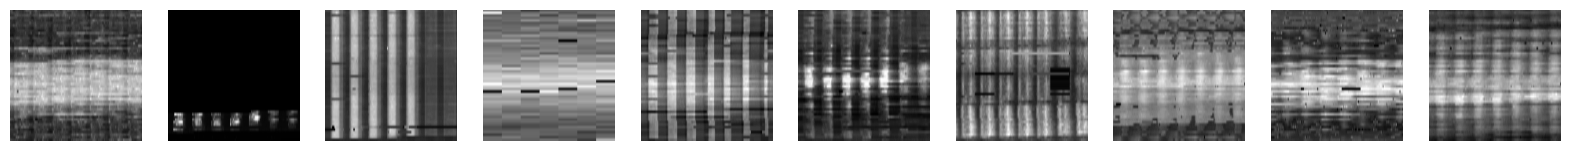

In [ ]:
# Generate 10 unique random indices
random_indices = random.sample(range(X_train.shape[0]), 10)

# Extract the randomly selected images
random_images = X_train[random_indices]

# Now random_images has shape [10, 1, 168, 168]
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

# Loop through axes and random images to display
for idx, ax in enumerate(axes):
    # First, squeeze to remove the channel dimension
    image = random_images[idx].squeeze()

    # Display resized image
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # to remove the axes for clarity

# Display all
plt.show()

In [ ]:
metadata = df_meta[[#'building_id',#'site_id',
           'primaryspaceusage',
           #'sqm',
           'lat','lng']]
metadata['meter'] = metadata.index.str.split('_',expand=True).get_level_values(0)

one_hot_encoded = pd.get_dummies(metadata['meter'])
metadata = pd.concat([metadata, one_hot_encoded], axis=1)
metadata = metadata.drop('meter', axis=1)

one_hot_encoded = pd.get_dummies(metadata['primaryspaceusage'])
metadata = pd.concat([metadata, one_hot_encoded], axis=1)
metadata = metadata.drop('primaryspaceusage', axis=1)

def encode_str_columns(df):
    encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df.loc[:, column] = encoder.fit_transform(df[column])
    return df

metadata = encode_str_columns(metadata)

#metadata = (metadata-0.5)*2

<ipython-input-52-bc5823a3877a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['meter'] = metadata.index.str.split('_',expand=True).get_level_values(0)


In [ ]:
metadata_2016 = metadata.copy()
metadata_2016.index=metadata_2016.index+'_2016'
metadata_2017 = metadata.copy()
metadata_2017.index=metadata_2017.index+'_2017'
metadata = pd.concat([metadata_2016, metadata_2017], axis=0)

In [ ]:
metadata['year'] = metadata.index.str.split('_',expand=True).get_level_values(-1)
metadata['year'] = metadata['year'].astype('int')
metadata

,lat,lng,chilledwater,electricity,gas,hotwater,steam,Education,Entertainment/public assembly,Lodging/residential,Office,Public services,year
chilledwater_Fox_lodging_Stephen_2016,33.424425,-111.92814,1,0,0,0,0,0,0,1,0,0,2016
chilledwater_Fox_lodging_Stephan_2016,33.424425,-111.92814,1,0,0,0,0,0,0,1,0,0,2016
chilledwater_Fox_office_Israel_2016,33.424425,-111.92814,1,0,0,0,0,0,0,0,1,0,2016
chilledwater_Fox_education_Lilly_2016,33.424425,-111.92814,1,0,0,0,0,1,0,0,0,0,2016
chilledwater_Fox_education_Gayla_2016,33.424425,-111.92814,1,0,0,0,0,1,0,0,0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
steam_Eagle_lodging_Casey_2017,37.406733,-77.80613,0,0,0,0,1,0,0,1,0,0,2017
steam_Eagle_office_Tia_2017,37.406733,-77.80613,0,0,0,0,1,0,0,0,1,0,2017
steam_Eagle_office_Remedios_2017,37.406733,-77.80613,0,0,0,0,1,0,0,0,1,0,2017
steam_Eagle_office_Patrice_2017,37.406733,-77.80613,0,0,0,0,1,0,0,0,1,0,2017


In [ ]:
metadata_original = metadata.copy()
metadata = (metadata-metadata.min())/(metadata.max()-metadata.min())

In [ ]:
#y_train = preprocessing.LabelEncoder().fit_transform(metadata.loc[train_data.columns, 'temperature_avg_encode'])
y_train = metadata.loc[train_data.columns]
#y_train = keras.utils.to_categorical(y_train, 4)
y_train = y_train.values
y_train.shape

(2702, 13)

In [ ]:
#y_test = preprocessing.LabelEncoder().fit_transform(metadata.loc[test_data.columns, 'temperature_avg_encode'])
y_test = metadata.loc[test_data.columns]
#y_test = keras.utils.to_categorical(y_test, 4)
y_test = y_test.values
y_test.shape

(901, 13)

In [ ]:
# Create new directory
save_path = "./preprocessed_data_168x168_2years"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save NumPy arrays
np.save(os.path.join(save_path, 'X_train.npy'), X_train)
np.save(os.path.join(save_path, 'X_test.npy'), X_test)
np.save(os.path.join(save_path, 'y_train.npy'), y_train)
np.save(os.path.join(save_path, 'y_test.npy'), y_test)

# Save Pandas DataFrames as pickle files
train_data.to_pickle(os.path.join(save_path, 'train_data.pkl'))
test_data.to_pickle(os.path.join(save_path, 'test_data.pkl'))
metadata.to_pickle(os.path.join(save_path, 'metadata.pkl'))
metadata_original.to_pickle(os.path.join(save_path, 'metadata_original.pkl'))

In [ ]:
# Set the path to the folder containing saved files
load_path = "./preprocessed_data_168x168_2years"

# Load saved NumPy arrays
X_train = np.load(os.path.join(load_path, 'X_train.npy'))
X_test = np.load(os.path.join(load_path, 'X_test.npy'))
y_train = np.load(os.path.join(load_path, 'y_train.npy'))
y_test = np.load(os.path.join(load_path, 'y_test.npy'))

# Load saved Pandas DataFrames
train_data = pd.read_pickle(os.path.join(load_path, 'train_data.pkl'))
test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
metadata = pd.read_pickle(os.path.join(load_path, 'metadata.pkl'))
metadata_original = pd.read_pickle(os.path.join(load_path, 'metadata_original.pkl'))